In [1]:
%pip install timm==1.0.3
%pip install wandb # I personally use wandb for results visualizations
!git clone https://github.com/Adamdad/rational_kat_cu.git
%cd rational_kat_cu
%pip install -e .

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 31.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: timm
    Found existing installation: timm 1.0.12
    Uninstalling timm-1.0.12:
      Successfully uninstalled timm-1.0.12
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Cloning into 'rational_kat_cu'...
remote: Enumerating objects: 2037, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 2037 (delta 75), reused 72 (delta 35), pack-reused 1917 (from 2)
Receiving objects: 100% (2037/2037), 275.76 KiB | 4.84 MiB/s, done.
Resolving deltas: 100% (1288/1288), done.
/kaggle/working/rational_kat_cu
Obtaining file:///kaggle/working/rational_kat_cu
  Preparing metadata (setup.py) ... done
  Running setup.py develop for kat_rational
Note: you may need to resta

In [2]:
%ls

example/  kat_rational/  README.md  setup.py  src/  tests/


In [3]:
!git clone https://github.com/Adamdad/kat.git

Cloning into 'kat'...
remote: Enumerating objects: 197, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 197 (delta 12), reused 13 (delta 5), pack-reused 171 (from 1)
Receiving objects: 100% (197/197), 1.71 MiB | 11.96 MiB/s, done.
Resolving deltas: 100% (116/116), done.


In [4]:
%cd kat

/kaggle/working/rational_kat_cu/kat


In [5]:
%mv katransformer.py ..

In [6]:
%cd ..

/kaggle/working/rational_kat_cu


In [7]:
%cd kat_rational
%pip install -e .

/kaggle/working/rational_kat_cu/kat_rational
Obtaining file:///kaggle/working/rational_kat_cu/kat_rational
ERROR: file:///kaggle/working/rational_kat_cu/kat_rational does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
Note: you may need to restart the kernel to use updated packages.


In [8]:
%cd ..

/kaggle/working/rational_kat_cu


In [9]:
!pip install triton

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.1/253.1 MB 6.8 MB/s eta 0:00:000:00:0100:01


In [34]:
ls

checkpoints/  example/  kat/              kat_rational/  README.md  src/
data/         images/   katransformer.py  __pycache__/   setup.py   tests/


In [33]:
os.makedirs("/kaggle/working/rational_kat_cu/images")

In [10]:
import os
import itertools
import torch
import timm
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# IMPORTANT: Import the module that registers your KAT models.
# This ensures that timm knows about 'kat_tiny_patch16_224'.
import katransformer

/kaggle/working/rational_kat_cu/kat_rational/rational_triton.py:244: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/kaggle/working/rational_kat_cu/kat_rational/rational_triton.py:273: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx: torch.autograd.Function, grad_output: Tensor):
/kaggle/working/rational_kat_cu/kat_rational/rational_triton2d.py:228: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/kaggle/working/rational_kat_cu/kat_rational/rational_triton2d.py:240: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cu

In [11]:
import sys
sys.path.append("/kaggle/working/rational_kat_cu/src")

In [12]:
%pip list | grep kat

kat_rational                       0.4                  /kaggle/working/rational_kat_cu/src
Note: you may need to restart the kernel to use updated packages.


In [13]:
import sys
sys.path.append("/kaggle/working/rational_kat_cu/kat")

In [14]:
class EarlyStopper:
    """
    Early stopping handler that saves model checkpoints and stops training when 
    validation loss stops improving.
    """
    def __init__(self, model, save_path: Path, patience: int, min_delta: float):
        """
        Args:
            model: The model being trained.
            save_path: Where to save the model checkpoint.
            patience: Number of epochs to wait before stopping.
            min_delta: Minimum change in loss to qualify as an improvement.
        """
        self.model = model
        self.save_path = save_path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        os.makedirs(os.path.dirname(save_path), exist_ok=True)


    def save_checkpoint(self, model_state, validation_loss:float, epoch:int, optimizer_state=None):
        """
        Save checkpoint
        Args:
            model_state: The model we want to save
            validation_loss: Validation loss
            epoch: epoch we are in
            optimizer_state: The state of the optimizer (Optional)
        """
        checkpoint = {
            'model' : model_state,
            'epoch': epoch,
            'validation_loss': validation_loss
        }
        if optimizer_state is not None:
            checkpoint['optimizer_state_dict'] = optimizer_state

        torch.save(checkpoint, self.save_path)
        print(f'Checkpoint saved at epoch {epoch} to {self.save_path}')


    def early_stop(self, validation_loss:float, epoch=None, optimizer_state=None):
        """
        Check if training should stop and save checkpoint if loss improved.
        Returns True if training should stop.
        """
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            self.save_checkpoint(self.model.state_dict(), validation_loss, epoch, optimizer_state)
            return False
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter +=1
            if self.counter >= self.patience:
                return True
        return False

In [15]:
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    """
    Completes training for one epoch
    Args:
        model: The model to train
        train_loader: The train_dataset in PyTorch
        optimizer: The optimizer used (Adam)
        criterion: The criterion used (CrossEntropyLoss())
        device: The device the training takes place : CPU/GPU
    """
    model.train()
    total_loss = 0
    for x,y in train_loader:
        x , y = x.float().to(device) , y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    return avg_loss
    

In [16]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Completes validation for one epoch
    Args:
        model: The model to train
        val_loader: The validation dataset in PyTorch
        optimizer: The optimizer used (Adam)
        criterion: The criterion used (CrossEntropyLoss())
        device: The device the training takes place : CPU/GPU
    """
    model.eval()
    total_loss = 0
    for x,y in val_loader:
        x , y = x.float().to(device), y.to(device)
        outputs = model(x)
        loss = criterion(outputs, y)
        total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)

    return avg_loss

In [17]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    Plot the confusion matrix.
    """
    if normalize:
        row_sums = cm.sum(axis=1)[:, np.newaxis]
        row_sums[row_sums == 0] = 1
        cm = cm.astype('float') / row_sums
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right", fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=9)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    os.makedirs('images', exist_ok=True)
    plt.savefig(f'images/{title}.png')
    plt.close()

def plot_training_history(history, title):
    """Plot training history including losses and learning rate.
    
    Args:
        history: Dictionary containing training history
    """

    # Plot losses
    plt.figure(figsize=(12, 8))
    plt.plot(history['train_loss'], label='Training Loss', color='blue')
    plt.plot(history['val_loss'], label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title}')
    plt.legend()
    plt.grid(True)
    plt.savefig('images/{}.png'.format(title))

In [18]:
def train_model(model, train_loader, val_loader, optimizer, criterion,
                epochs:int = 10, save_path: Path = Path("./"), device:str = 'cuda',
                title: str = "Training History"):
    """
    Train the model with early stopping and save the best checkpoint.
    Plot and save the confusion matrix along with the training and 
    validation loss graphs
    Args:
        model
        train_loader
        val_loader
        optimizer
        criterion
        epochs
        save_path: The path the model will be saved
        device
        title: The title of the training and validation loss graph of the model
    """
    history = {'train_loss': [], 'val_loss': []}
    early_stopper = EarlyStopper(model, save_path, patience=5, min_delta=0)

    for epoch in range(epochs):
        print(f"Training epoch {epoch+1}")
        train_loss = train_one_epoch(
            model, train_loader, optimizer, criterion, device
        )
        val_loss = validate_one_epoch(
            model, val_loader, criterion, device
        )

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        print(f'Epoch {epoch+1}/{epochs}: Train Loss = {train_loss if train_loss is not None else "N/A"}, Val Loss = {val_loss if val_loss is not None else "N/A"}')

        if early_stopper.early_stop(val_loss, epoch, optimizer.state_dict()):
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Load the best model checkpoint
    checkpoint = torch.load(save_path, map_location=device)
    model.load_state_dict(checkpoint['model'])
    print(f"Loaded best model from epoch {checkpoint['epoch']+1} with validation loss: {checkpoint['validation_loss']:.4f}")
    
    plot_training_history(history, title=title)

    return model

In [19]:
def finetune_kan(model, lr: float = 1e-5, 
                 batch_size:int = 32, epochs:int = 10, device: str = 'cuda',
                 title:str = 'KAT MNIST Finetuning'):
    """
    Finetuning a Kan Model
    Args:
        model: The pretrained_model for finetuning
        lr: Learning rate
        batch_size: The batch size
        Epochs: Number of epochs for the finetuning process
        device: The device the finetuning takes place
        title: The title of the confusion matrix
    """

    # Define transforms for MNIST: resize, convert grayscale to 3 channels, normalize.
    transform = transforms.Compose([
        transforms.Resize((28, 28)),                # Resize to 28x28 instead of 224x224
        transforms.Grayscale(num_output_channels=1),  # Single channel for MNIST
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    # Load the MNIST datasets.
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    val_dataset   = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Separate parameters into backbone and head so that they do not overlap.
    backbone_params = []
    head_params = []
    for name,param in model.named_parameters():
        if "head" in name:
            head_params.append(param)
        else:
            backbone_params.append(param)

    optimizer = torch.optim.AdamW([
        {"params": backbone_params, "lr": lr/10},
        {"params": head_params, "lr": lr}
    ], weight_decay=1e-4)

    criterion = torch.nn.CrossEntropyLoss()

    # Define the checkpoint path for early stopping.
    save_path = "./checkpoints/transfer/kat_MNIST_transfer_finetuned.pth"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    
    # Train the model using the training utilities.
    model = train_model(model, train_loader, val_loader, optimizer, criterion,
                epochs, save_path, device, title=title)

    return model

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Loading pretrained KAT model from Hugging Face...")
# Load the pretrained KAT-T (from ViT) model using the hf_hub identifier.
model = timm.create_model('hf_hub:adamdad/kat_tiny_patch16_224.vitft', pretrained=True)

Loading pretrained KAT model from Hugging Face...


config.json:   0%|          | 0.00/566 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/timm/models/_hub.py:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(cached_file, map_location='cpu')


In [21]:
# Step 2: Replace the patch embedding layer.
# Create a new patch embedding layer for MNIST images:
# - img_size=28 (MNIST images are 28x28)
# - patch_size=4 (so you'll get (28/4)^2 = 49 patches)
# - in_chans=1 (MNIST is grayscale)
from timm.models.layers import PatchEmbed, trunc_normal_
from torch import nn
# - embed_dim remains the same as the original model (pretrained weights in later layers can be reused)
new_patch_embed = PatchEmbed(img_size=28, patch_size=4, in_chans=1, embed_dim=model.embed_dim)
model.patch_embed = new_patch_embed

In [22]:

# Step 3: Reinitialize the positional embeddings.
# The original model's pos_embed was sized for (224/16)^2 (+1 token if class token exists),
# so we need a new positional embedding for our new number of patches.
if model.pos_embed is not None:
    num_tokens = new_patch_embed.num_patches + (1 if getattr(model, 'has_class_token', False) else 0)
    new_pos_embed = torch.zeros(1, num_tokens, model.embed_dim)
    trunc_normal_(new_pos_embed, std=0.02)
    model.pos_embed = nn.Parameter(new_pos_embed)


In [23]:
# Step 4: Reset the classifier head for 10 classes.
model.reset_classifier(num_classes=10)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the adapted model to the device.
model = model.to(DEVICE)

In [24]:
import os
os.environ["TRITON_DISABLE_KERNELS"] = "1"
os.environ["TRITON_DISABLE_JIT"] = "1"

Training epoch 1
Epoch 1/5: Train Loss = 0.9021906394640604, Val Loss = 0.9242214237729581
Checkpoint saved at epoch 0 to ./checkpoints/transfer/kat_MNIST_transfer_finetuned.pth
Training epoch 2
Epoch 2/5: Train Loss = 0.8511682586987813, Val Loss = 0.8239958314849927
Checkpoint saved at epoch 1 to ./checkpoints/transfer/kat_MNIST_transfer_finetuned.pth
Training epoch 3
Epoch 3/5: Train Loss = 0.8048438452402751, Val Loss = 0.796006234404378
Checkpoint saved at epoch 2 to ./checkpoints/transfer/kat_MNIST_transfer_finetuned.pth
Training epoch 4
Epoch 4/5: Train Loss = 0.7654940055847168, Val Loss = 0.747713497176338
Checkpoint saved at epoch 3 to ./checkpoints/transfer/kat_MNIST_transfer_finetuned.pth
Training epoch 5
Epoch 5/5: Train Loss = 0.7264359287977219, Val Loss = 0.7403216066356665
Checkpoint saved at epoch 4 to ./checkpoints/transfer/kat_MNIST_transfer_finetuned.pth


<ipython-input-18-eb3e168ef660>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_path, map_location=device)


Loaded best model from epoch 5 with validation loss: 0.7403


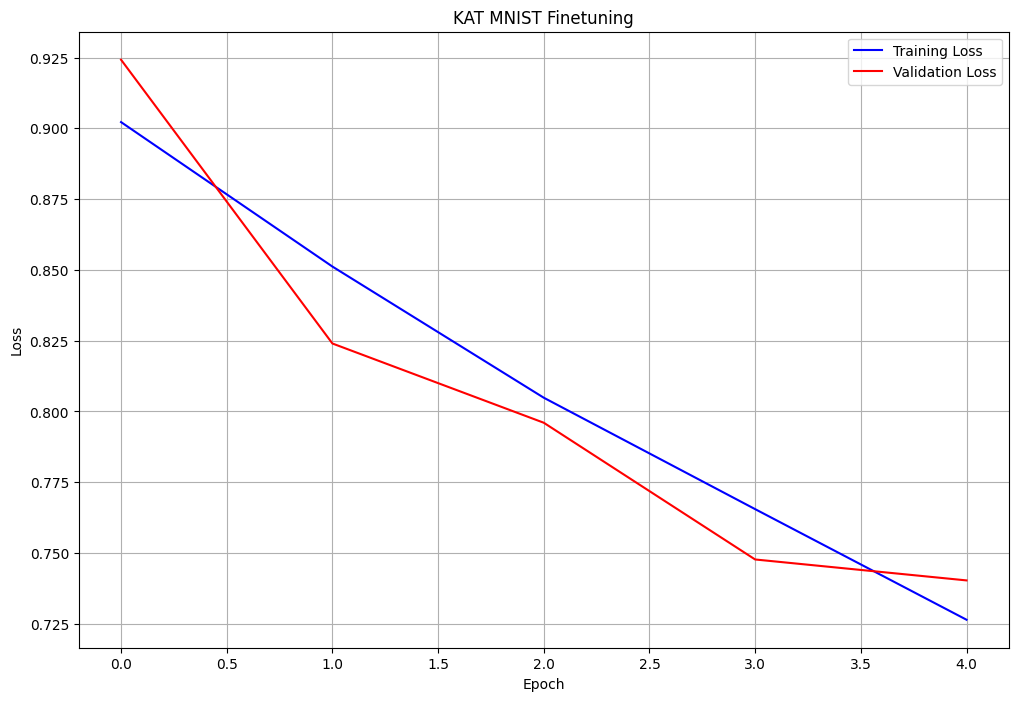

In [35]:
finetuned_model = finetune_kan(model, lr = 1e-5,
                 batch_size = 32, epochs = 5, device = 'cuda',
                 title = 'KAT MNIST Finetuning')

In [36]:
def gaussianNoise_kan(model, lr: float = 1e-5, 
                 batch_size:int = 32, epochs:int = 10, device: str = 'cuda',
                 title:str = 'KAT MNIST Finetuning', noise_std: float = 0.1):
    """
    Finetuning a Kan Model with Gaussian Noise
    Args:
        model: The pretrained_model for finetuning
        lr: Learning rate
        batch_size: The batch size
        epochs: Number of epochs for the finetuning process
        device: The device the finetuning takes place
        title: The title of the confusion matrix
        noise_std: Standard deviation for Gaussian noise
    """
    
    # Function to add Gaussian noise
    class AddGaussianNoise(torch.nn.Module):
        def __init__(self, mean=0.0, std=0.1):
            super(AddGaussianNoise, self).__init__()
            self.mean = mean
            self.std = std
        
        def forward(self, tensor):
            if self.training:  # Only add noise during training
                noise = torch.randn(tensor.size()) * self.std + self.mean
                return tensor + noise
            else:
                return tensor
    
    # Define transforms for MNIST: resize, convert grayscale to 3 channels, normalize.
    transform = transforms.Compose([
        transforms.Resize((28, 28)),                # Resize to 28x28
        transforms.Grayscale(num_output_channels=1),  # Single channel for MNIST
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
        AddGaussianNoise(std=noise_std)  # Add Gaussian noise
    ])
    
    # Load the MNIST datasets.
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    val_dataset   = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Separate parameters into backbone and head so that they do not overlap.
    backbone_params = []
    head_params = []
    for name, param in model.named_parameters():
        if "head" in name:
            head_params.append(param)
        else:
            backbone_params.append(param)

    optimizer = torch.optim.AdamW([
        {"params": backbone_params, "lr": lr/10},
        {"params": head_params, "lr": lr}
    ], weight_decay=1e-4)

    criterion = torch.nn.CrossEntropyLoss()

    # Define the checkpoint path for early stopping.
    save_path = "./checkpoints/transfer/kat_MNIST_transfer_finetuned.pth"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Train the model using the training utilities.
    model = train_model(model, train_loader, val_loader, optimizer, criterion,
                        epochs, save_path, device, title=title)

    return model


In [42]:
# Function to add Gaussian noise
class AddGaussianNoise(torch.nn.Module):
    def __init__(self, mean=0.0, std=0.1):
        super(AddGaussianNoise, self).__init__()
        self.mean = mean
        self.std = std
        
    def forward(self, tensor):
        if self.training:  # Only add noise during training
            noise = torch.randn(tensor.size()) * self.std + self.mean
            return tensor + noise
        else:
            return tensor

Training epoch 1
Epoch 1/5: Train Loss = 0.746319752017657, Val Loss = 0.7552971792297242
Checkpoint saved at epoch 0 to ./checkpoints/transfer/kat_MNIST_transfer_finetuned.pth
Training epoch 2
Epoch 2/5: Train Loss = 0.7165853968143463, Val Loss = 0.725220983401655
Checkpoint saved at epoch 1 to ./checkpoints/transfer/kat_MNIST_transfer_finetuned.pth
Training epoch 3
Epoch 3/5: Train Loss = 0.6931902740955352, Val Loss = 0.6791828776510379
Checkpoint saved at epoch 2 to ./checkpoints/transfer/kat_MNIST_transfer_finetuned.pth
Training epoch 4
Epoch 4/5: Train Loss = 0.6670543869495392, Val Loss = 0.6641544998644259
Checkpoint saved at epoch 3 to ./checkpoints/transfer/kat_MNIST_transfer_finetuned.pth
Training epoch 5
Epoch 5/5: Train Loss = 0.644712078388532, Val Loss = 0.6663229135564341
Loaded best model from epoch 4 with validation loss: 0.6642


<ipython-input-18-eb3e168ef660>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_path, map_location=device)


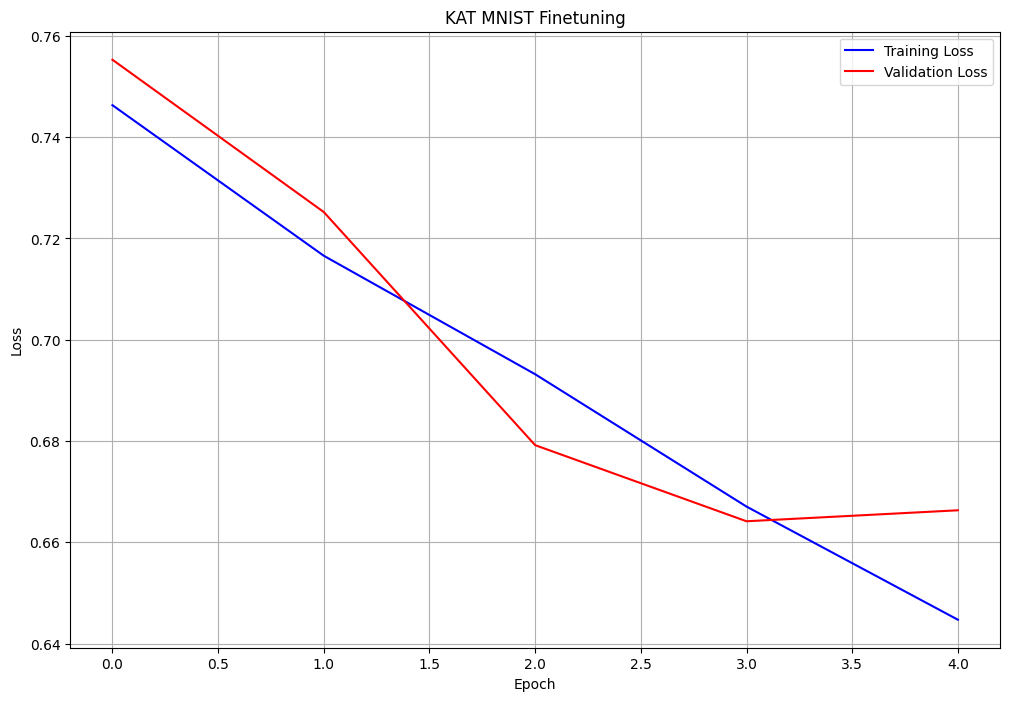

In [37]:
gaussianNoise_model = gaussianNoise_kan(model, lr = 1e-5,
                 batch_size = 32, epochs = 5, device = 'cuda',
                 title = 'KAT MNIST Finetuning')

In [47]:
def saltPepperNoise_model(model, lr: float = 1e-5, 
                 batch_size:int = 32, epochs:int = 10, device: str = 'cuda',
                 title:str = 'KAT MNIST Finetuning', sp_prob: float = 0.05):
    """
    Finetuning a Kan Model with Salt & Pepper Noise
    Args:
        model: The pretrained_model for finetuning
        lr: Learning rate
        batch_size: The batch size
        epochs: Number of epochs for the finetuning process
        device: The device the finetuning takes place
        title: The title of the confusion matrix
        sp_prob: Probability of salt & pepper noise
    """
    
    # Function to add Salt & Pepper noise
    class AddSaltPepperNoise(torch.nn.Module):
        def __init__(self, prob=0.05):
            super(AddSaltPepperNoise, self).__init__()
            self.prob = prob
        
        def forward(self, tensor):
            if self.training:  # Only add noise during training
                # Generate a random mask
                rand = torch.rand(tensor.size())
                salt_mask = (rand < self.prob / 2).float()
                pepper_mask = (rand > 1 - self.prob / 2).float()
                
                # Apply salt & pepper noise
                tensor = tensor * (1 - salt_mask - pepper_mask) + salt_mask + 0 * pepper_mask
                tensor = torch.clamp(tensor, 0.0, 1.0)  # Ensure values are within [0, 1]
                
                return tensor
            else:
                return tensor
    
    # Define transforms for MNIST: resize, convert grayscale to 3 channels, normalize.
    transform = transforms.Compose([
        transforms.Resize((28, 28)),                # Resize to 28x28
        transforms.Grayscale(num_output_channels=1),  # Single channel for MNIST
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
        AddSaltPepperNoise(prob=sp_prob)  # Add Salt & Pepper noise
    ])
    
    # Load the MNIST datasets.
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    val_dataset   = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Separate parameters into backbone and head so that they do not overlap.
    backbone_params = []
    head_params = []
    for name, param in model.named_parameters():
        if "head" in name:
            head_params.append(param)
        else:
            backbone_params.append(param)

    optimizer = torch.optim.AdamW([
        {"params": backbone_params, "lr": lr/10},
        {"params": head_params, "lr": lr}
    ], weight_decay=1e-4)

    criterion = torch.nn.CrossEntropyLoss()

    # Define the checkpoint path for early stopping.
    save_path = "./checkpoints/transfer/kat_MNIST_transfer_finetuned_sp.pth"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Train the model using the training utilities.
    model = train_model(model, train_loader, val_loader, optimizer, criterion,
                        epochs, save_path, device, title=title)

    return model


In [48]:
# Function to add Salt & Pepper noise
class AddSaltPepperNoise(torch.nn.Module):
    def __init__(self, prob=0.05):
        super(AddSaltPepperNoise, self).__init__()
        self.prob = prob
        
    def forward(self, tensor):
        if self.training:  # Only add noise during training
                # Generate a random mask
            rand = torch.rand(tensor.size())
            salt_mask = (rand < self.prob / 2).float()
            pepper_mask = (rand > 1 - self.prob / 2).float()
                
                # Apply salt & pepper noise
            tensor = tensor * (1 - salt_mask - pepper_mask) + salt_mask + 0 * pepper_mask
            tensor = torch.clamp(tensor, 0.0, 1.0)  # Ensure values are within [0, 1]
                
            return tensor
        else:
            return tensor

In [ ]:
saltPepperNoise_model = saltPepperNoise_model(model, lr = 1e-5,
                 batch_size = 32, epochs = 5, device = 'cuda',
                 title = 'KAT MNIST Finetuning')

Training epoch 1
Epoch 1/5: Train Loss = 1.8182501995722453, Val Loss = 1.5469816972653325
Checkpoint saved at epoch 0 to ./checkpoints/transfer/kat_MNIST_transfer_finetuned_sp.pth
Training epoch 2
Epoch 2/5: Train Loss = 1.458720871448517, Val Loss = 1.3588980975242468
Checkpoint saved at epoch 1 to ./checkpoints/transfer/kat_MNIST_transfer_finetuned_sp.pth
Training epoch 3
Epoch 3/5: Train Loss = 1.3014052311579387, Val Loss = 1.2217766097940195
Checkpoint saved at epoch 2 to ./checkpoints/transfer/kat_MNIST_transfer_finetuned_sp.pth
Training epoch 4


In [ ]:
def occlusionsNoise_kan(model, lr: float = 1e-5, 
                 batch_size:int = 32, epochs:int = 10, device: str = 'cuda',
                 title:str = 'KAT MNIST Finetuning', occlusion_prob: float = 0.3, occlusion_size: int = 8):
    """
    Finetuning a Kan Model with Occlusions Noise
    Args:
        model: The pretrained_model for finetuning
        lr: Learning rate
        batch_size: The batch size
        epochs: Number of epochs for the finetuning process
        device: The device the finetuning takes place
        title: The title of the confusion matrix
        occlusion_prob: Probability of applying occlusion
        occlusion_size: Size of the occluded square patch
    """
    
    # Function to add Occlusions noise
    class AddOcclusions(torch.nn.Module):
        def __init__(self, prob=0.3, size=8):
            super(AddOcclusions, self).__init__()
            self.prob = prob
            self.size = size
        
        def forward(self, tensor):
            if self.training and torch.rand(1).item() < self.prob:  # Only add occlusions during training
                _, h, w = tensor.size()
                
                # Randomly select the top-left corner of the occlusion
                x = torch.randint(0, w - self.size, (1,)).item()
                y = torch.randint(0, h - self.size, (1,)).item()
                
                # Apply the occlusion (set the patch to black)
                tensor[:, y:y+self.size, x:x+self.size] = 0.0
                
                return tensor
            else:
                return tensor
    
    # Define transforms for MNIST: resize, convert grayscale to 3 channels, normalize.
    transform = transforms.Compose([
        transforms.Resize((28, 28)),                # Resize to 28x28
        transforms.Grayscale(num_output_channels=1),  # Single channel for MNIST
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
        AddOcclusions(prob=occlusion_prob, size=occlusion_size)  # Add Occlusions noise
    ])
    
    # Load the MNIST datasets.
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    val_dataset   = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Separate parameters into backbone and head so that they do not overlap.
    backbone_params = []
    head_params = []
    for name, param in model.named_parameters():
        if "head" in name:
            head_params.append(param)
        else:
            backbone_params.append(param)

    optimizer = torch.optim.AdamW([
        {"params": backbone_params, "lr": lr/10},
        {"params": head_params, "lr": lr}
    ], weight_decay=1e-4)

    criterion = torch.nn.CrossEntropyLoss()

    # Define the checkpoint path for early stopping.
    save_path = "./checkpoints/transfer/kat_MNIST_transfer_finetuned_occlusions.pth"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Train the model using the training utilities.
    model = train_model(model, train_loader, val_loader, optimizer, criterion,
                        epochs, save_path, device, title=title)

    return model


In [45]:
# Function to add Occlusions noise
class AddOcclusions(torch.nn.Module):
    def __init__(self, prob=0.3, size=8):
        super(AddOcclusions, self).__init__()
        self.prob = prob
        self.size = size
        
    def forward(self, tensor):
        if self.training and torch.rand(1).item() < self.prob:  # Only add occlusions during training
            _, h, w = tensor.size()
                
                # Randomly select the top-left corner of the occlusion
            x = torch.randint(0, w - self.size, (1,)).item()
            y = torch.randint(0, h - self.size, (1,)).item()
                
                # Apply the occlusion (set the patch to black)
            tensor[:, y:y+self.size, x:x+self.size] = 0.0
                
            return tensor
        else:
            return tensor

In [ ]:
occlusionsNoise_model = occlusionsNoise_kan(model, lr = 1e-5,
                 batch_size = 32, epochs = 5, device = 'cuda',
                 title = 'KAT MNIST Finetuning')

In [39]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Function to evaluate the model on a given DataLoader
def evaluate_model(model, dataloader, device='cuda'):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    
    # Generate confusion matrix and classification report
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds)
    print(report)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, cm, report

# Define transformations for each noise type
def get_transforms(noise_type=None):
    base_transforms = [
        transforms.Resize((28, 28)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ]
    
    if noise_type == 'gaussian':
        base_transforms.append(AddGaussianNoise(mean=0.0, std=0.1))
    elif noise_type == 'salt_pepper':
        base_transforms.append(AddSaltPepperNoise(prob=0.05))
    elif noise_type == 'occlusions':
        base_transforms.append(AddOcclusions(prob=0.3, size=8))
        
    return transforms.Compose(base_transforms)

# Load datasets for each noise type
def get_dataloaders(batch_size=32):
    dataloaders = {}
    noise_types = [None, 'gaussian', 'salt_pepper', 'occlusions']
    
    for noise in noise_types:
        transform = get_transforms(noise)
        dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)
        dataloaders[noise if noise else 'clean'] = dataloader
    
    return dataloaders

# Main evaluation function
def evaluate_all_models(model, device='cuda'):
    dataloaders = get_dataloaders()
    results = {}
    
    for noise_type, dataloader in dataloaders.items():
        print(f"\nEvaluating on {noise_type} data:")
        accuracy, cm, report = evaluate_model(model, dataloader, device)
        results[noise_type] = {'accuracy': accuracy, 'confusion_matrix': cm, 'report': report}
    
    return results






Evaluating on clean data:
Accuracy: 77.65%
              precision    recall  f1-score   support

           0       0.87      0.78      0.82       980
           1       0.95      0.99      0.97      1135
           2       0.66      0.51      0.58      1032
           3       0.74      0.69      0.71      1010
           4       0.89      0.77      0.82       982
           5       0.59      0.70      0.64       892
           6       0.75      0.84      0.79       958
           7       0.82      0.84      0.83      1028
           8       0.75      0.79      0.77       974
           9       0.74      0.83      0.78      1009

    accuracy                           0.78     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.78      0.77     10000



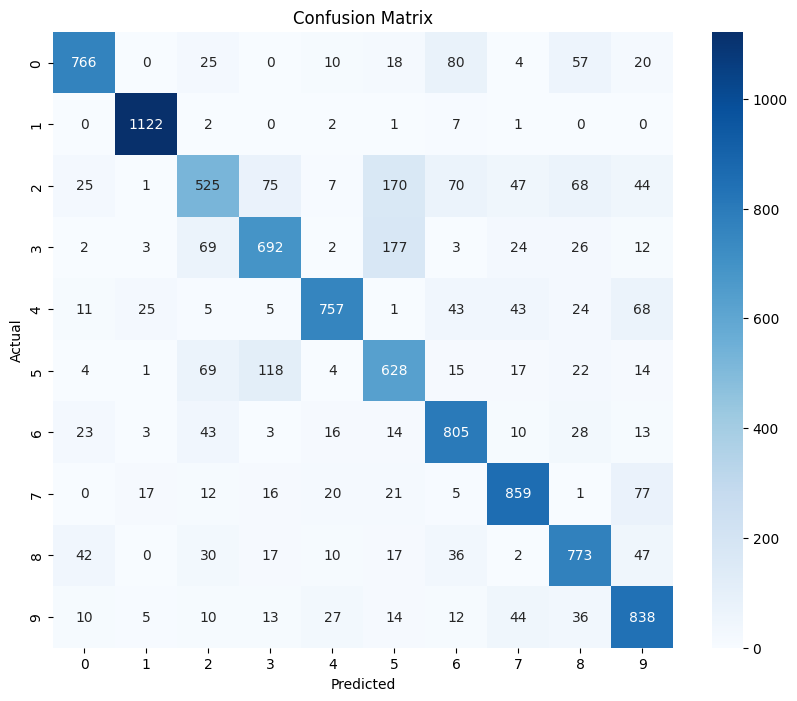


Evaluating on gaussian data:
Accuracy: 77.12%
              precision    recall  f1-score   support

           0       0.86      0.79      0.82       980
           1       0.98      0.99      0.98      1135
           2       0.61      0.53      0.56      1032
           3       0.73      0.69      0.71      1010
           4       0.79      0.86      0.82       982
           5       0.60      0.67      0.63       892
           6       0.75      0.81      0.78       958
           7       0.80      0.85      0.82      1028
           8       0.76      0.76      0.76       974
           9       0.79      0.74      0.76      1009

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



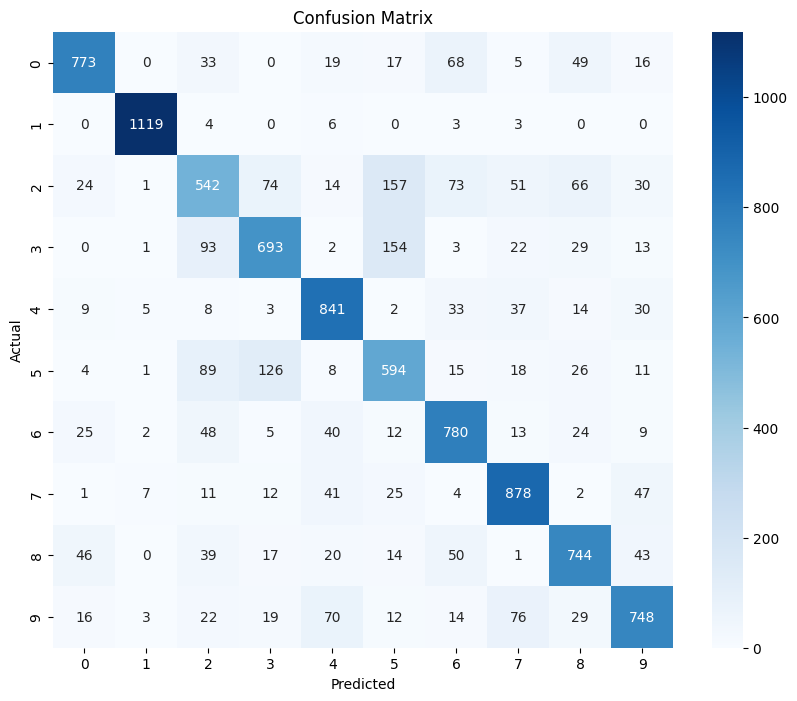


Evaluating on salt_pepper data:
Accuracy: 8.78%
              precision    recall  f1-score   support

           0       0.16      0.08      0.10       980
           1       0.06      0.18      0.09      1135
           2       0.15      0.00      0.01      1032
           3       0.14      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.09      0.51      0.16       892
           6       0.00      0.00      0.00       958
           7       0.16      0.01      0.02      1028
           8       0.10      0.13      0.11       974
           9       0.13      0.00      0.01      1009

    accuracy                           0.09     10000
   macro avg       0.10      0.09      0.05     10000
weighted avg       0.10      0.09      0.05     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


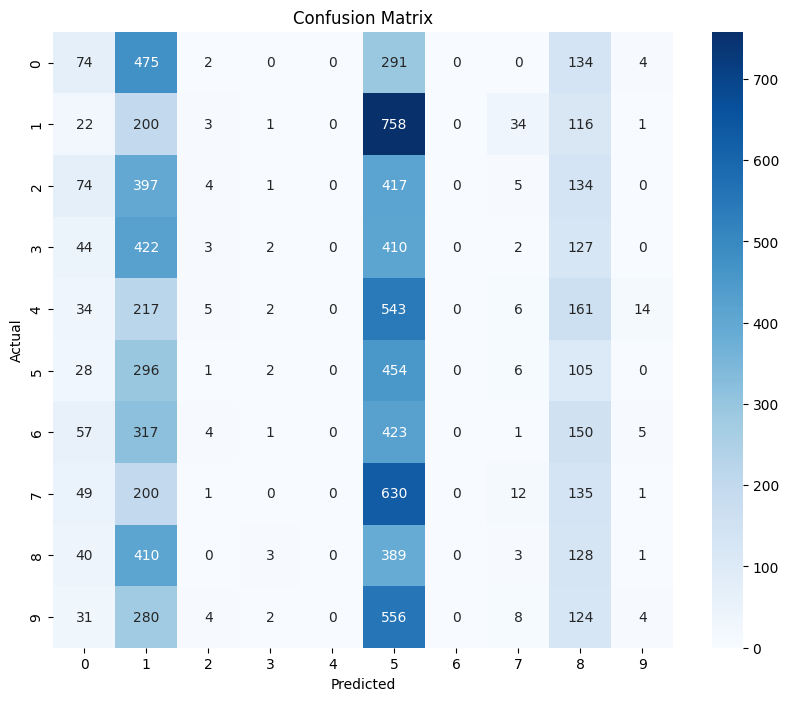


Evaluating on occlusions data:
Accuracy: 63.92%
              precision    recall  f1-score   support

           0       0.76      0.67      0.71       980
           1       0.95      0.70      0.81      1135
           2       0.61      0.42      0.49      1032
           3       0.70      0.58      0.64      1010
           4       0.71      0.65      0.68       982
           5       0.57      0.60      0.58       892
           6       0.74      0.72      0.73       958
           7       0.80      0.61      0.69      1028
           8       0.36      0.84      0.50       974
           9       0.68      0.61      0.65      1009

    accuracy                           0.64     10000
   macro avg       0.69      0.64      0.65     10000
weighted avg       0.69      0.64      0.65     10000



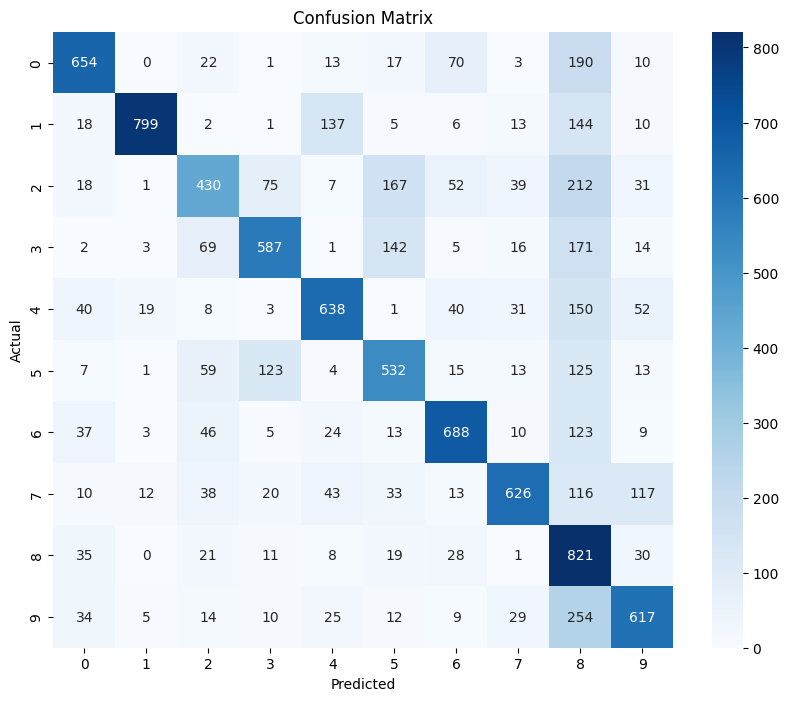

In [46]:
model = finetuned_model # Load your fine-tuned model here
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
results = evaluate_all_models(model, device)